In [1]:
# !pip install -q --user --upgrade pandas matplotlib matplotlib-venn seaborn

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib_venn import venn3, venn3_circles
from IPython.display import Markdown as md

In [3]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [4]:
plt.rcParams["figure.figsize"] = (13,9)

# Gaming advertisement
***
##### commissioned by: "Ice" - online gaming store

The Success of a Game - 
What does that mean, and how do we measure it?


To answer that, it's needed to understand the mindset of gamers, and the history and current state of the gaming industry as a whole.  

In this (digital) paper, we are going to explore relations between various gaming consoles,  
different genres and and ratings (ESRB), 
and try to assess the weight of both user and critic ratings on the market performance of a title.

Different gamers have different tastes, even more so when they are from different cultures, and even continents\!  
We will compare North America, Europe and Japan (biggest gaming markets),  
and see what the gamers prefer.

This report aims to recognize patterns that show whether a game will succeed or fail (sales wise),  
and recommend which platforms and genres should the store focus advertisement on for the next year.  

Data operated on is from open-source online sources, packaged as a .csv file.

<a class="anchor" id="0_toc"></a>
# Table of Contents
***

1. [Datasets](#1-data_files)
    <br />&nbsp;&nbsp;[Overview](#1-data_overview)
2. [Preprocess](#2-preprocess)
    1. [Column names](#2-preprocess_columns)
    2. [Duplicates](#2-preprocess_duplicates)
    3. [Missing values](#2-preprocess_na)
    4. [Data types](#2-preprocess_dtypes)
    5. [Synthetic features](#2-preprocess_synthetic)
    <br />[Conclusions](#2-preprocess_conclusions)
3. [Analysis](#3-analysis)
    1. [Titles per year](#3-analysis_year_release)
    2. [Total sales by platform](#3-analysis_sales_by_platform)
    3. [Top platforms' sales distribution by year](#3-analysis_sales_distribution)
    4. [Potentially profitable platforms](#3-analysis_profitable_platforms)
    5. [Reviews effect on sales](#3-analysis_reviews)
    6. [Comparison of genres](#3-analysis_genres)
    <br />[Conclusions](#3-analysis_conclusions)
4. [Regional user profiles](#4-region_profiles)
    1. [Top 5 platforms by region](#4-region_platforms)
    2. [Top 5 genres by region](#4-region_genres)
    3. [ESRB ratings](#4-region_esrb)
    <br />[Conclusions](#4-region_conclusions)
4. [Hypotheses testing](#5-hypotheses)
    1. [User ratings of Xbox One and PC platforms](#5-platforms_user_ratings)
    2. [User ratings of Action and Sports genres](#5-genres_user_ratings)
    <br />[Conclusions](#5-hypotheses_conclusions)
6. [Conclusions](#6-conclusions)

<a class="anchor" id="1-data_files"></a>
## Parse Dataset
***
[back to Table of Contents](#0_toc)

In [5]:
filename = 'games.csv'

In [6]:
def print_file_metadata(filepath):
    """Prints metadata related to files"""
    
    try:
        !du -m "$filepath"      # filesize in MiB
        !stat -c %y "$filepath" # date, filename
        !file "$filepath"       # file type, encoding
        !wc -l "$filepath"      # line count
        !head -n3 "$filepath"   # file preview
    except Exception as e:
        print(e)

In [7]:
def load_file(file):
    """Returns a parsed DataFrame"""
    
    display(md(f'\n***\n#### Loading {file}..\n\n'))

    filepath = f'/datasets/{file}'
    if not os.path.isfile(filepath):
        filepath = file

    print_file_metadata(filepath)

    return pd.read_csv(filepath)

In [8]:
df = load_file('games.csv')


***
#### Loading games.csv..



2	games.csv
stat: illegal option -- c
usage: stat [-FlLnqrsx] [-f format] [-t timefmt] [file ...]
games.csv: UTF-8 Unicode text, with CRLF line terminators
   16716 games.csv
Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,,,


Dataset was parsed successfully.

<a class="anchor" id="1-data_overview"></a>
### Overview
[back to Table of Contents](#0_toc)

In [9]:
df.info()
display(
    md('<br />data preview:'),
    df.head(),
    md(f'shape: {df.shape}'),
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<br />data preview:

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


shape: (16715, 11)

Columns overview from the dataset's originator:

- Name
- Platform
- Year_of_Release
- Genre
- NA_sales (North American sales in USD million)
- EU_sales (sales in Europe in USD million)
- JP_sales (sales in Japan in USD million)
- Other_sales (sales in other countries in USD million)
- Critic_Score (maximum of 100)
- User_Score (maximum of 10)
- Rating (ESRB)

ESRB ratings:  
https://www.esrb.org/ratings-guide/  
https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board  

- Rating Pending (RP)
- Early Childhood (EC) - defunct
- Kids to Adults (K–A) - renamed to "Everyone" in 1998
- Everyone (E) 
- Everyone 10+ (E10+) 
- Teen (T) 
- Mature 17+ (M)
- Adults Only 18+ (AO) 

<a class="anchor" id="2-preprocess"></a>
## Preprocess
***
[back to Table of Contents](#0_toc)
1. [Column names](#2-preprocess_columns)
2. [Duplicates](#2-preprocess_duplicates)
3. [Missing values](#2-preprocess_na)
4. [Data types](#2-preprocess_dtypes)
5. [Synthetic features](#2-preprocess_synthetic)
<br />[Conclusions](#2-preprocess_conclusions)

<a class="anchor" id="2-preprocess_columns"></a>
### Column names
[up](#2-preprocess)

Normalizing names to lower case

In [10]:
df.columns = df.columns.str.casefold()
# df.columns

<a class="anchor" id="2-preprocess_duplicates"></a>
### Duplicates
[up](#2-preprocess)

In [11]:
duplicated = df[df[['name', 'platform', 'year_of_release']].duplicated(keep=False)]
duplicated

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [12]:
df.drop(duplicated.iloc[-2:].index, inplace=True)
del duplicated

<a class="anchor" id="2-preprocess_na"></a>
### Missing values
[up](#2-preprocess)

In [13]:
def missing_values_summary(df, sort_values=True, hide_empty=False):
    """Displays a summary of missing values, including count and ratio"""
    
    missing_values_count = df.isna().sum().rename('count')
    summary = pd.concat([
        missing_values_count,
        (missing_values_count / df.shape[0]).round(4).rename('ratio')
    ], axis=1)
    
    if sort_values:
        summary = summary.sort_values('count')
        
    if hide_empty:
        summary = summary.query('count != 0')
    
    return summary

# missing_values_summary(df)
# missing_values_summary(df[['name', 'genre']])

In [14]:
def get_missing_values(df, *columns, show_count=False, show_sample=False):
    """Returns missing values entries for either columns"""
    
    assert columns, 'Must specify at least 1 column'
        
    results = df.query(' or '.join(f'{col}.isna()' for col in columns))
        
    if show_sample:
        display(results.sample(show_sample))
    
    if show_count:
        display(missing_values_summary(df[[*columns]]))
        
    return results

# get_missing_values(df, 'year_of_release', show_count=True)
# get_missing_values(df, 'name', 'genre', show_sample=True);

In [15]:
def get_value_counts(series):
    """Returns value counts, with ratio"""
    
    assert isinstance(series, pd.Series), 'Must be of type pd.Series'
    
    return pd.concat([
        series.value_counts().rename('count'),
        series.value_counts(normalize=True).rename('ratio')
    ], axis=1).sort_index()

# get_value_counts(df['user_score'])

In [16]:
missing_values_summary(df, hide_empty=True)

,count,ratio
name,1,0.0001
genre,1,0.0001
year_of_release,269,0.0161
user_score,6700,0.4009
rating,6765,0.4048
critic_score,8577,0.5132


There are missing values present.  

The source of this data is from various 'open source' locations,  
and as such might be incomplete, or even erroneous. 

Further addressing each column in detail:

#### 'name' and 'genre' columns

There is a same amount of missing values for both columns, checking whether they are related.

In [17]:
name_genre_na = get_missing_values(df, 'name', 'genre', show_count=True, show_sample=1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


,count,ratio
name,1,0.0001
genre,1,0.0001


Both of the above entries are missing various metrics, other than those checked.  
Since it constitutes a miniscule portion of the data (less than 0.01%),  
they can be safely removed, without adverse effects.

In [18]:
df.drop(name_genre_na.index, inplace=True)
print('Were the rows dropped?', len(get_missing_values(df, 'name', 'genre')) == 0)

Were the rows dropped? True


#### 'year_of_release' column

In [19]:
year_na = get_missing_values(df, 'year_of_release', show_count=True, show_sample=1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14350,Bikkuriman Daijiten,DS,NaN,Misc,0.0,0.0,0.03,0.0,NaN,NaN,NaN


,count,ratio
year_of_release,269,0.0161


The missing values are due to an incomplete data set.  
Over the next sections, games will be analysed by years,  
and these entries will interrupt the process.

It is a small portion of the dataset (< 2%), and can be safely removed.

In [20]:
df.drop(year_na.index, inplace=True)
print('Were the rows dropped?', len(get_missing_values(df, 'year_of_release')) == 0)

Were the rows dropped? True


#### 'user_score' column

In [21]:
def review_missing_values_platforms_years(df, column, top=5):
    return (df[df[column].isna()]
            [['platform', 'year_of_release']]
            .groupby('platform')
            .agg(['min', 'max'])
            .sort_values(('year_of_release', 'max'), ascending=False)
            .head(top))

In [22]:
user_score_na = get_missing_values(df, 'user_score', show_count=True, show_sample=1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13135,Kamiwaza,PS2,2006.0,Action,0.0,0.0,0.05,0.0,NaN,NaN,NaN


,count,ratio
user_score,6605,0.4017


40% of the data has no user scores.  
checking the range of values:

In [23]:
user_score_value_counts = get_value_counts(df['user_score']).sort_values('count', ascending=False)
display(user_score_value_counts.head())
print(f'shape: {user_score_value_counts.shape}')

,count,ratio
tbd,2376,0.241513
7.8,322,0.032730
8,285,0.028969
8.2,276,0.028054
8.3,252,0.025615


shape: (96, 2)


96 unique values (approx 0.0 - 10.0, matches the column description).  
Contains a value 'tbd' (abbreviation of "To be determined"), which appears for 1/4 of the data.  
'tbd' is a dummy value which equals no value in practice.  
It can be replaced with NaN and treated as such.

In [24]:
df['user_score'] = df['user_score'].where(df['user_score'] != 'tbd', np.NaN)
print('Was the value replaced successfully?', 'tbd' not in get_value_counts(df['user_score']).index)

Was the value replaced successfully? True


After replacing 'tbd' value, the true missing values count is at ~55%.  
Using median to fill in missing values, by platform and genre:

In [25]:
display(
    md('#### Missing values'),
    review_missing_values_platforms_years(df, 'user_score'),
    missing_values_summary(df[['user_score']]))

#### Missing values

year_of_release        
                     min     max
platform                        
XOne              2013.0  2016.0
3DS               2011.0  2016.0
X360              2005.0  2016.0
WiiU              2012.0  2016.0
Wii               2006.0  2016.0

,count,ratio
user_score,8981,0.5462


We can not fill in missing scores meaningfully, since about 50% of the column is missing.  
If the amount missing would have been less than 10%, could try imputation techniques to fill  
\- perhaps grouped by platform and genre for optimal results.

#### 'critic_score' column

In [26]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [27]:
critic_score_na = get_missing_values(df, 'critic_score', show_count=True, show_sample=1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5431,Angry Birds Star Wars,3DS,2013.0,Strategy,0.15,0.15,0.0,0.03,NaN,3,E


,count,ratio
critic_score,8461,0.5146


Again, we can not fill in missing scores meaningfully, since about 50% of the column is missing.

#### 'rating' column

In [28]:
rating_na = get_missing_values(df, 'rating', show_count=True, show_sample=2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
4844,"Transformers: The Game (XBox 360, PS2, PS3, Wi...",PS3,2007.0,Action,0.32,0.03,0.01,0.04,NaN,NaN,NaN
16559,Katekyoo Hitman Reborn! Kindan no Yami no Delta,Wii,2008.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN


,count,ratio
rating,6676,0.406


'rating' column has 40% missing values.

In [29]:
get_value_counts(df['rating'])

,count,ratio
AO,1,0.000102
E,3920,0.401351
E10+,1393,0.142623
EC,8,0.000819
K-A,3,0.000307
M,1536,0.157264
RP,1,0.000102
T,2905,0.297430


Filling in missing values with dummy value 'Unknown'.

In [30]:
df['rating'].fillna('Unknown', inplace=True)
print('Were missing values filled?', df['rating'].isna().sum() == 0)

Were missing values filled? True


<a class="anchor" id="2-preprocess_dtypes"></a>
### Data types
[up](#2-preprocess)

In [31]:
def dtypes(df):
    """Displays data types for each column, and corresponding unique values count"""
    
    return pd.concat([
        df.dtypes.rename('dtype'),
        df.nunique().rename('unique values')
    ], axis=1)

In [32]:
def extract_categories(df, columns, inplace=False):
    """Returns a lookup table of categories, with corresponding ids"""
    
    def extract(series):
        return pd.Series(series.unique(), name=series.name).sort_values().reset_index(drop=True)
    
    def invert(series):
        return pd.Series(index=series.values, data=series.index, name=series.name)
    
    if not isinstance(columns, list):
        columns = [columns]
    
    refs = [extract(df[col]) for col in columns]
    
    if inplace:
        for i, column in enumerate(columns):
            ref = invert(refs[i])
            # print(df[column].apply(lambda x:ref[x]))
            df[f'{column}_id'] = df[column].apply(lambda x:ref[x])
            df.drop(column, axis=1, inplace=True)

    return refs if len(refs) > 1 else refs[0]

In [33]:
dtypes(df)

,dtype,unique values
name,object,11426
platform,object,31
year_of_release,float64,37
genre,object,12
na_sales,float64,401
eu_sales,float64,307
jp_sales,float64,244
other_sales,float64,155
critic_score,float64,81
user_score,object,95


In [34]:
df[['user_score', 'critic_score']].head(1)

,user_score,critic_score
0,8,76.0


The following transformations will be made:
- year_of_release -> int
- user_score -> float
- critic_score -> scale down to base 10 (like user_score)
- platform -> categorization
- genre -> categorization
- rating -> categorization

#### 'year_of_release' dtype transform

In [35]:
df['year_of_release'] = df['year_of_release'].astype('int')

#### 'user_score' dtype transform

In [36]:
df['user_score'] = df['user_score'].astype('float')

#### 'critic_score' scale

In [37]:
df['critic_score'] = df['critic_score'] / 10

In [38]:
df[['user_score', 'critic_score']].describe()

,user_score,critic_score
count,7462.000000,7982.000000
mean,7.126548,6.899261
std,1.499429,1.392005
min,0.000000,1.300000
25%,6.400000,6.000000
50%,7.500000,7.100000
75%,8.200000,7.900000
max,9.700000,9.800000


#### 'platform' categorization

In [39]:
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [40]:
platform_ref = extract_categories(df, columns='platform', inplace=True)

#### 'genre' categorization

In [41]:
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [42]:
genre_ref = extract_categories(df, columns='genre', inplace=True)

#### 'rating' categorization

In [43]:
df['rating'].unique()

array(['E', 'Unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [44]:
get_value_counts(df['rating'])

,count,ratio
AO,1,0.000061
E,3920,0.238399
E10+,1393,0.084717
EC,8,0.000487
K-A,3,0.000182
M,1536,0.093414
RP,1,0.000061
T,2905,0.176671
Unknown,6676,0.406009


In [45]:
df.query('rating == "AO"')

,name,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,platform_id,genre_id
875,Grand Theft Auto: San Andreas,2005,1.26,0.61,0.0,0.09,9.3,8.6,AO,29,0


'AO' (adults only) can be combined with 'M' (mature 17+) for the purposes of this analysis.

In [46]:
df.query('rating == "EC"').sample(2)

,name,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,platform_id,genre_id
7586,"Ni Hao, Kai-lan: New Year's Celebration",2009,0.19,0.00,0.0,0.01,NaN,NaN,EC,4,3
6764,Dora the Explorer: Journey to the Purple Planet,2005,0.12,0.09,0.0,0.03,NaN,7.0,EC,16,1


'EC' (early childhood) can be combined with 'E' (everyone).

In [47]:
df.query('rating == "K-A"')

,name,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,platform_id,genre_id
656,Theme Hospital,1997,2.30,0.10,0.00,0.00,NaN,9.0,K-A,13,11
903,PaRappa The Rapper,1996,0.26,0.16,1.46,0.03,9.2,7.4,K-A,15,3
16681,Worms 2,1997,0.00,0.01,0.00,0.00,NaN,8.1,K-A,13,11


'K-A' (kids to adults) can be combined with 'E' (everyone).

In [48]:
df.query('rating == "RP"')

,name,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,platform_id,genre_id
14270,Supreme Ruler: Cold War,2011,0.0,0.03,0.0,0.01,6.3,6.8,RP,13,11


RP (rating pending) can be removed altogether (promotional material).

In [49]:
df.drop(df[df['rating'] == 'RP'].index, inplace=True)

In [50]:
df['rating'].replace({
    'AO': 'M',
    'EC': 'E',
    'K-A': 'E',
}, inplace=True)

In [51]:
display(
    md('Verification of operations:'),
    get_value_counts(df['rating']))

Verification of operations:

,count,ratio
E,3931,0.239083
E10+,1393,0.084722
M,1537,0.093480
T,2905,0.176682
Unknown,6676,0.406033


In [52]:
rating_ref = extract_categories(df, columns='rating', inplace=True)

Overview of resulting dataframe:

In [53]:
display(
    df.sample(),
    df.dtypes)

,name,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,platform_id,genre_id,rating_id
7758,Rock Band Country Track Pack,2009,0.18,0.0,0.0,0.02,NaN,NaN,17,3,1


name                object
year_of_release      int64
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
platform_id          int64
genre_id             int64
rating_id            int64
dtype: object

<a class="anchor" id="2-preprocess_synthetic"></a>
### Synthetic features
[up](#2-preprocess)

Calculating the sum of total sales from all regions, per game.

In [54]:
df['total_sales'] = df[[col for col in df.columns if col.endswith('_sales')]].sum(axis=1)

Merging user_score and critic_score to a new unified metric, reviews_score.

In [55]:
df[['user_score', 'critic_score']].query('user_score.isna() and not critic_score.isna()').iloc[0].agg(
    lambda x:x.append(pd.Series(x.mean(), index=['reviews_score'])))

user_score       NaN
critic_score     8.5
reviews_score    8.5
dtype: float64

Mean aggregation disregards missing values, and will skew the results.  
Aggregating only non-missing values.

In [56]:
df['reviews_score'] = (df[['user_score', 'critic_score']]
                       .query('~user_score.isna() and ~critic_score.isna()')
                       .agg('mean', axis=1))
print(f"Applied to {df['reviews_score'].count()} rows.")

Applied to 6892 rows.


Sum of missing values count, between the relevant columns:

In [57]:
df[['reviews_score', 'user_score', 'critic_score']].isna().sum(axis=1).value_counts().sort_index()

0    6892
2    1658
3    7892
dtype: int64

<a class="anchor" id="2-preprocess_conclusions"></a>
### Conclusions
[up](#2-preprocess)

* Column names normalized to lower case
* Missing values:  
&nbsp;&nbsp; year - removed rows  
&nbsp;&nbsp; user / critic ratings - ignored  
&nbsp;&nbsp; ESRB ratings - filled in with dummy value  
* Data types:  
&nbsp;&nbsp; platform, genre and ESRB ratings categorised and extracted to look up tables.  
&nbsp;&nbsp; conversions:  
&nbsp;&nbsp; &nbsp;&nbsp; year -> int  
&nbsp;&nbsp; &nbsp;&nbsp; user score -> float  
&nbsp;&nbsp; &nbsp;&nbsp; critic score -> scaled to 0-10  
* Synthetic features:  
&nbsp;&nbsp; calculated total_sales from regional sales  
&nbsp;&nbsp; calculated reviews_score from mean of both user_score and critic_score

<a class="anchor" id="3-analysis"></a>
## Analysis
***
[back to Table of Contents](#0_toc)

Searching for potentially profitable categories for the upcoming year,  
exploring distributions and correlation of sales, platforms, genres and ratings.

1. [Titles per year](#3-analysis_year_release)
2. [Total sales by platform](#3-analysis_sales_by_platform)
3. [Top platforms' sells distribution by year](#3-analysis_sales_distribution)
4. [Potentially profitable platforms](#3-analysis_profitable_platforms)
5. [Reviews effect on sales](#3-analysis_reviews)
6. [Comparison of genres](#3-analysis_genres)
<br />[Conclusions](#3-analysis_conclusions)

In [58]:
def calculate_descriptive_stats(series):
    """
    Returns a Tuple of:
      lower extreme, upper extreme,
      IQR, Q1, Q3
    """
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_extreme = max(q1 - (1.5 * iqr), series.min())
    upper_extreme = min(q3 + (1.5 * iqr), series.max())
    
    return lower_extreme, upper_extreme, iqr, q1, q3

In [59]:
def detect_outliers(df, verbose=False):
    """Detects potential outliers, using IQR method"""
    
    def detect(series):
        lower_extreme, upper_extreme, _, _, _ = calculate_descriptive_stats(series)
        outliers = series[(series < lower_extreme) | (series > upper_extreme)]
        print(f'{series.name} outliers: {len(outliers)} ({len(outliers)/len(series):.2%})')
        print(f'lower extreme: {lower_extreme}  upper extreme: {upper_extreme}')
        
        if verbose:
            print(outliers)
            
        print()
    
    if isinstance(df, pd.DataFrame):
        for column in df.columns:
            detect(df[column])
    elif isinstance(df, pd.Series):
        detect(df)

<a class="anchor" id="3-analysis_year_release"></a>
### Titles per year
[up](#3-analysis)

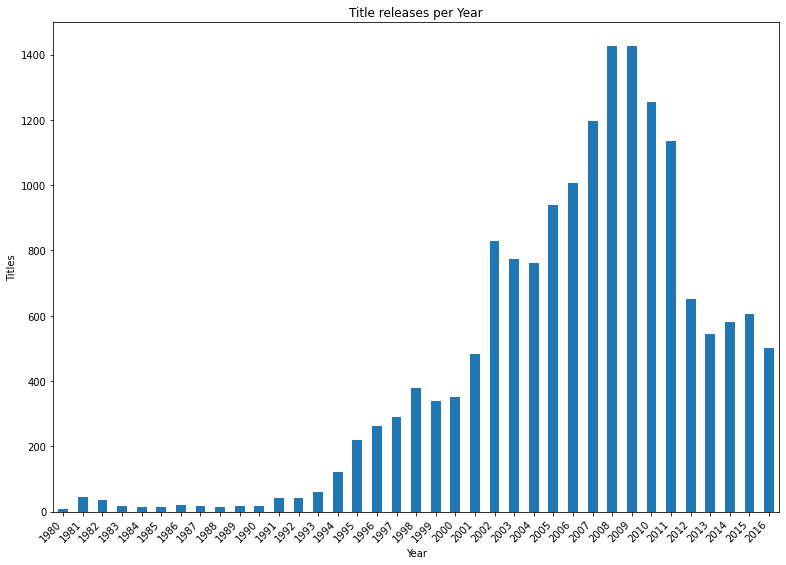

In [60]:
df['year_of_release'].value_counts().sort_index().plot.bar(
    title='Title releases per Year', 
    xlabel='Year',
    ylabel='Titles')
plt.xticks(rotation=45, ha='right')
plt.show();

The gaming industry started to take off in the 90s.

The above bar plot raises some interesting questions.  
The exponentially growing tech industry of chips (and graphic chips),  
made it possible for new and powerful home gaming consoles to see the light of day,  
with Nintendo and Sony leading the way, and Microsoft following.  
From the early 90's and up until the peak of the number of titles released in years 2008-2009,  
gaming companies have released a growing number of titles each year,  
which gradually decreased and became stable at ~600 yearly titles around the year 2012.  
A possible explanation for this is that the companies producing the games decided to go for quality instead of quantity,  
caring for their user's opinion and feedback.  
Also, to combat gaming piracy and bootlegging,  
which increased with the rise of faster and cheaper broadband connections,  
many such developers resorted to an ecosystem of Virtual Goods, letting users spend money on in-game items,  
making it a very profitable avenue.

\- https://en.wikipedia.org/wiki/Video_game#Industry  
\- https://techcrunch.com/2015/10/31/the-history-of-gaming-an-evolving-community/  
\- https://www.adroitmarketresearch.com/press-release/virtual-goods-market

In [61]:
display(
    md(f"\# of releases before 1990: {len(df.query('year_of_release < 1990'))}  \n"
       f"\# of releases after 1990: {len(df.query('year_of_release >= 1990'))}"))

\# of releases before 1990: 205  
\# of releases after 1990: 16237

<a class="anchor" id="3-analysis_sales_by_platform"></a>
### Total sales by platform
[up](#3-analysis)

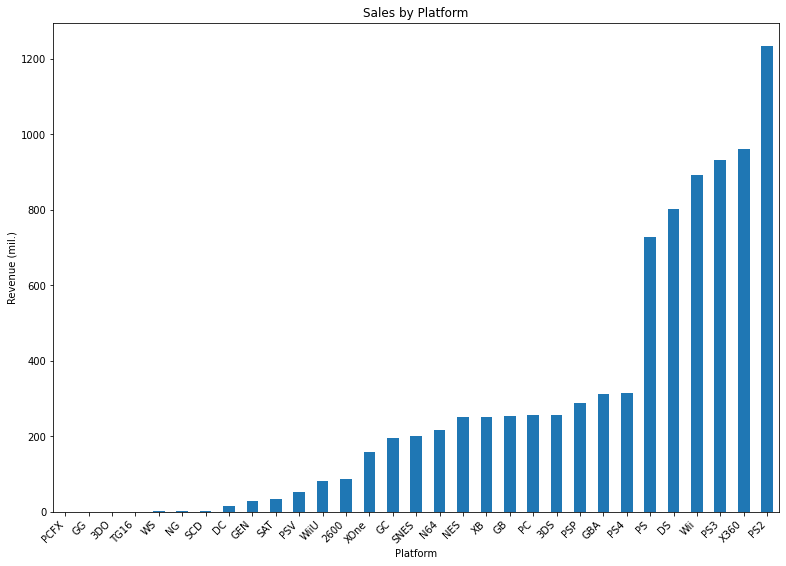

In [62]:
total_sales_by_platform = (df[['platform_id', 'total_sales']]
                           .groupby('platform_id')
                           .sum()
                           .sort_values('total_sales'))
total_sales_by_platform.plot.bar(
    title='Sales by Platform',
    xlabel='Platform',
    ylabel='Revenue (mil.)',
    legend=None)
labels = [platform_ref[id] for id in total_sales_by_platform.index.values]
plt.xticks(list(range(len(labels))), labels, rotation=45, ha='right')
plt.show();

The highest grossing platforms appear to be, in order:
* PS2
* Xbox 360
* PS3
* Wii
* DS
* PS

The top platforms are from the end of the 90's (PS), and the start of the 21st century.  
It coincides with the large number of titles released yearly,  
meaning the platforms with the highest total sales are the ones which had most games released for over the very prolific period of 1990 - 2010.

<a class="anchor" id="3-analysis_sales_distribution"></a>
### Top platforms' sales distribution by year
[up](#3-analysis)

In [63]:
highest_grossing_platforms = total_sales_by_platform[-6:].index.values
highest_grossing_platforms_slice = df.query('platform_id in @highest_grossing_platforms').copy()

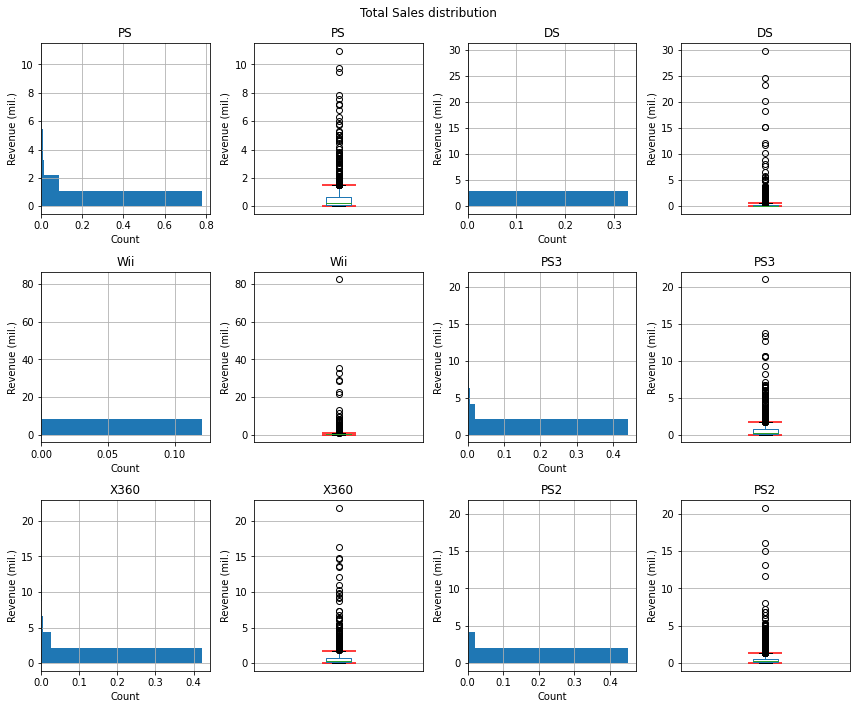

In [64]:
#def plot_top_platforms_distributions():

fig, axes = plt.subplots(3, 4, figsize=(12,10))
flat_axes = axes.flat

for i, platform_id in enumerate(highest_grossing_platforms):
    # print(i*2, i*2 + 1)
    ax_1 = flat_axes[i*2]
    ax_2 = flat_axes[i*2 + 1]
    platform_slice = highest_grossing_platforms_slice.query('platform_id == @platform_id')

    platform_slice.hist('total_sales', density=True, orientation='horizontal', ax=ax_1)
    ax_1.set_title(platform_ref[platform_id])
    ax_1.set_xlabel('Count')
    ax_1.set_ylabel('Revenue (mil.)')

    lower_extreme, upper_extreme, _, _, _ = calculate_descriptive_stats(platform_slice['total_sales'])
    platform_slice.boxplot('total_sales', ax=ax_2)
    ax_2.set_title(platform_ref[platform_id])
    ax_2.set_xticks([])
    ax_2.set_ylabel('Revenue (mil.)')
    ax_2.hlines([lower_extreme, upper_extreme], color='red', xmin=0.9, xmax=1.1)

plt.suptitle('Total Sales distribution')
fig.tight_layout()
plt.show()

Many outliers are noticeable, exploring further:

In [65]:
for platform_id in highest_grossing_platforms:
    detect_outliers(highest_grossing_platforms_slice
                    .query('platform_id == @platform_id')['total_sales']
                    .rename(platform_ref[platform_id]))

PS outliers: 114 (9.58%)
lower extreme: 0.01  upper extreme: 1.485

DS outliers: 232 (10.94%)
lower extreme: 0.01  upper extreme: 0.6000000000000001

Wii outliers: 134 (10.42%)
lower extreme: 0.01  upper extreme: 1.0837499999999998

PS3 outliers: 119 (9.12%)
lower extreme: 0.0  upper extreme: 1.735

X360 outliers: 127 (10.31%)
lower extreme: 0.01  upper extreme: 1.76

PS2 outliers: 248 (11.66%)
lower extreme: 0.0  upper extreme: 1.2800000000000002



Total sales is the target metric, outliers should not be removed unless it is irrational or erroneous data.  
Games can be best sellers, i.e. outside of the upper extreme limit, and still be considered a legitimate entry.

In [66]:
highest_grossing_platforms_slice['year_of_release'].sort_values().unique()

array([1985, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016])

In [67]:
suspect_anomaly = (highest_grossing_platforms_slice
                   .query('year_of_release == 1985')
                   .reset_index(drop=True))
suspect_anomaly

,name,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,platform_id,genre_id,rating_id,total_sales,reviews_score
0,Strongest Tokyo University Shogi DS,1985,0.0,0.0,0.02,0.0,NaN,NaN,4,0,4,0.02,NaN


In [68]:
platform_ref[4]

'DS'

the DS console did not exist in 1985, it is an anomaly. dropping the entry.

In [69]:
highest_grossing_platforms_slice.drop(
    highest_grossing_platforms_slice.query('year_of_release == 1985').index, inplace=True)
df.drop(suspect_anomaly.index, inplace=True)
del suspect_anomaly

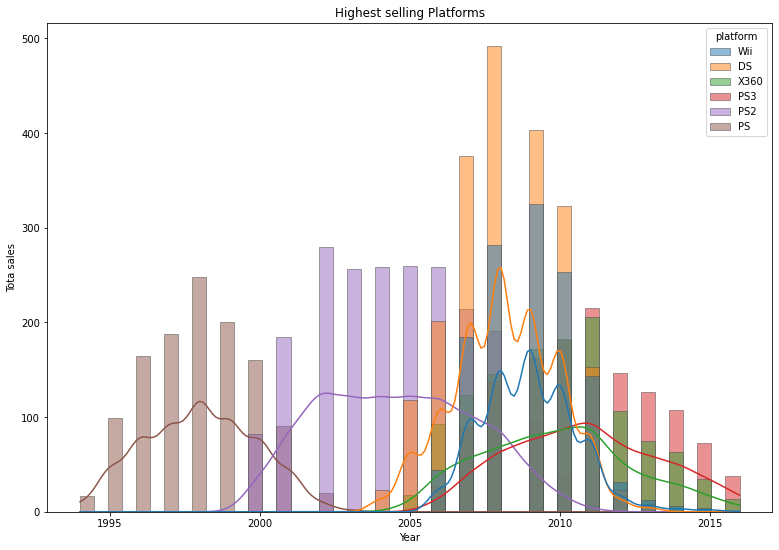

In [70]:
sns.histplot(
    highest_grossing_platforms_slice.join(platform_ref, on='platform_id'),
    x='year_of_release',
    hue='platform',
    kde=True,
    edgecolor=".3",
    linewidth=.5,
)
plt.title('Highest selling Platforms')
plt.xlabel('Year')
plt.ylabel('Tota sales')
plt.show();

The span in which a platform "rise & fall" (measured by revenue), seems to be ~10 years,  
with overlap occuring:
when one decreases in popularity, another one increases in parallel.

Judging by these trends, it appears that the past 5 years should be a good range to look for the next wave of popular consoles.

In [71]:
relevant_years = sorted(df['year_of_release'].unique())[-5:]
relevant_years

[2012, 2013, 2014, 2015, 2016]

By looking at PS and PS2 distributions above, it can be seen that PS has reached a peak in year '98, and then started decreasing.  
In parallel, PS2 appeared and started increasing.  
By the time the PS hit zero at around 2003, PS2 has reached its mid-life - and became the popular one.  
Then the same has happened for PS2 and PS3 / Xbox 360.  

The trend here is that once a newer generation console is released,  
games for older generations consoles sell less, and games for the newest generation consoles sell more.  
Looking at the plot, this transition process takes about 5 years (i.e. from PS1 median - 1998, to PS2 median - 2003).

<a class="anchor" id="3-analysis_profitable_platforms"></a>
### Potentially profitable platforms
[up](#3-analysis)

Selecting only platforms which have releases within the relevant range, found above.

In [72]:
def filter_platforms_by_release_years(df, years):
    """Selects the platforms that have all their released titles within the specified years"""
    
    min_year = min(years)
    max_year = max(years)
    platform_years_min_max = df.groupby('platform_id')['year_of_release'].agg(['min', 'max'])
    return platform_years_min_max.query('min >= @min_year and max <= @max_year').index.values

In [73]:
potential_popular_platforms_ids = filter_platforms_by_release_years(df, relevant_years)
potential_popular_platforms_ids

array([18, 27, 30])

In [74]:
potential_popular_platforms_slice = (df
                                     .query('platform_id in @potential_popular_platforms_ids')
                                     .join(platform_ref, on='platform_id'))

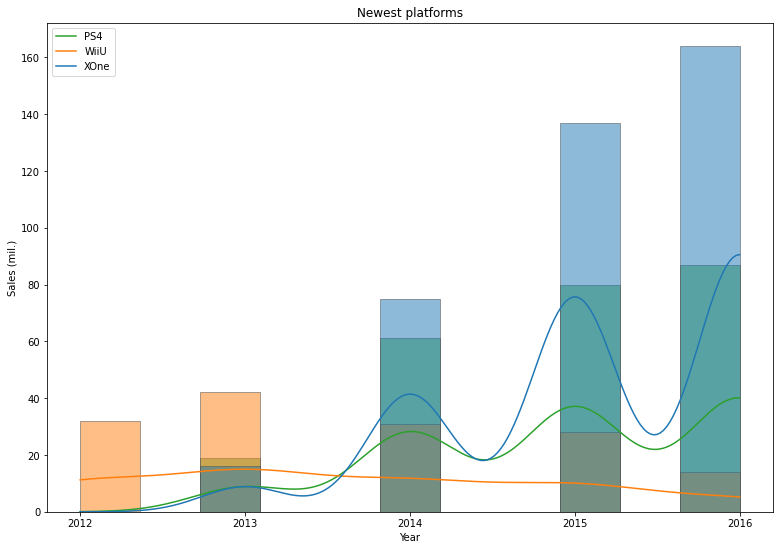

In [75]:
sns.histplot(
    potential_popular_platforms_slice,
    x='year_of_release',
    hue='platform_id',
    kde=True,
    palette="tab10",
    edgecolor=".3",
    linewidth=.5,
)
plt.title('Newest platforms')
plt.xlabel('Year')
plt.ylabel('Sales (mil.)')
plt.legend([platform_ref[id] for id in potential_popular_platforms_ids])
plt.xticks(ticks=relevant_years, labels=relevant_years)
plt.show();

Xbox One is the clear winner, with most sells,  
and not too far behind is the runner-up PS4, both seeing increase in sells.  
WiiU is left behind, with a decreasing curve.

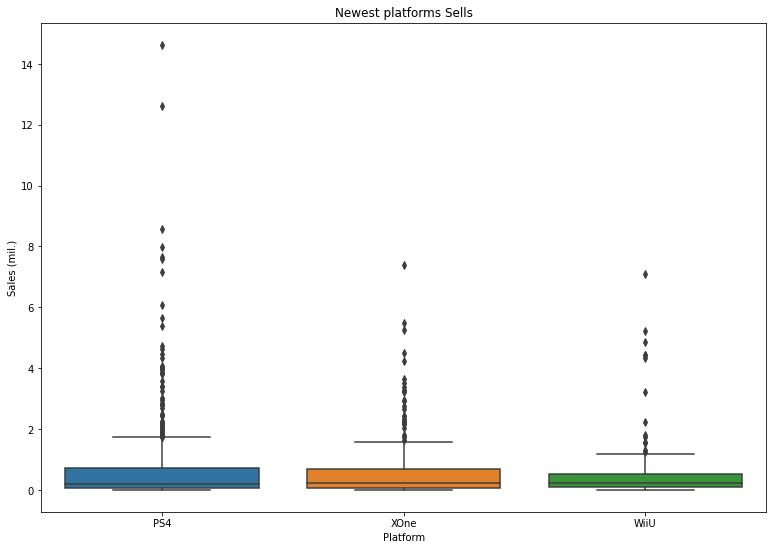

In [76]:
sns.boxplot(
    data=potential_popular_platforms_slice,
    y='total_sales',
    x='platform'
)
# plt.ylim(0, 4)
plt.title('Newest platforms Sells')
plt.xlabel('Platform')
plt.ylabel('Sales (mil.)')
plt.show();

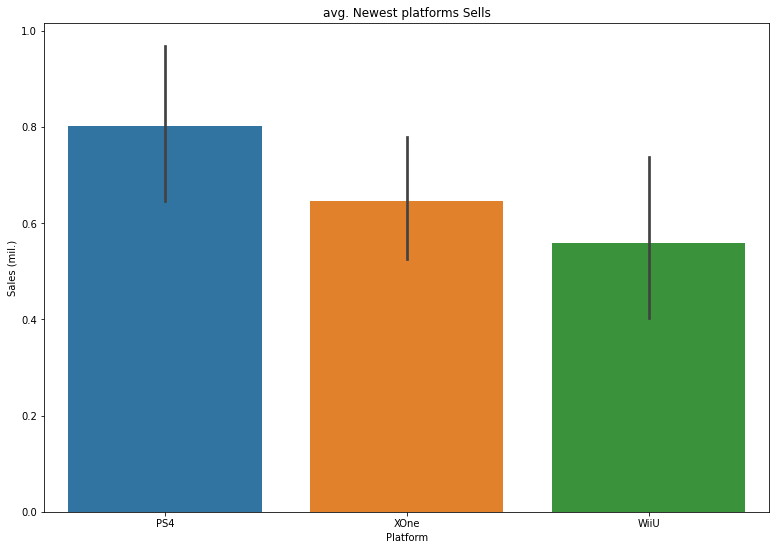

In [77]:
sns.barplot(
    data=potential_popular_platforms_slice,
    x='platform',
    y='total_sales'
)
plt.title('avg. Newest platforms Sells')
plt.xlabel('Platform')
plt.ylabel('Sales (mil.)')
plt.show();

The differences in sales between the 3 platforms are not significant (100k range),  
in comparison to the differences of overall sales for the most successfull platforms (10's mil. range).

<a class="anchor" id="3-analysis_reviews"></a>
### Reviews effect on sales
[up](#3-analysis)

Merging user scores with critic scores (by average), for easier analysis.

In [78]:
def plot_platform_review_sales_scatter(platform_id):
    platform_slice = potential_popular_platforms_slice.query('platform_id == @platform_id')
    sns.scatterplot(
        data=platform_slice,
        x='reviews_score',
        y='total_sales',
    )
    plt.title(f'{platform_ref[platform_id]} Sales / Reviews correlation')
    plt.xlabel('Score')
    plt.ylabel('Sales (mil.)')
    plt.show()
    return platform_slice

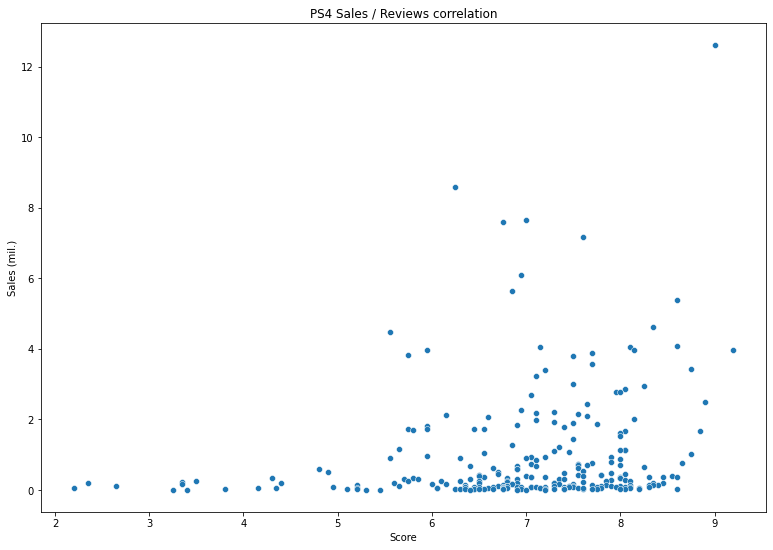

In [79]:
ps4_slice = plot_platform_review_sales_scatter((platform_ref == 'PS4').idxmax())

In [80]:
ps4_slice[['total_sales', 'reviews_score']].corr()

,total_sales,reviews_score
total_sales,1.000000,0.192338
reviews_score,0.192338,1.000000


There appears to be a very weak positive correlation.  
\* Correlation, by itself, does not imply causation - can't draw conclusions regarding cause and effect.

,total_sales,reviews_score
total_sales,1.000000,0.393891
reviews_score,0.393891,1.000000


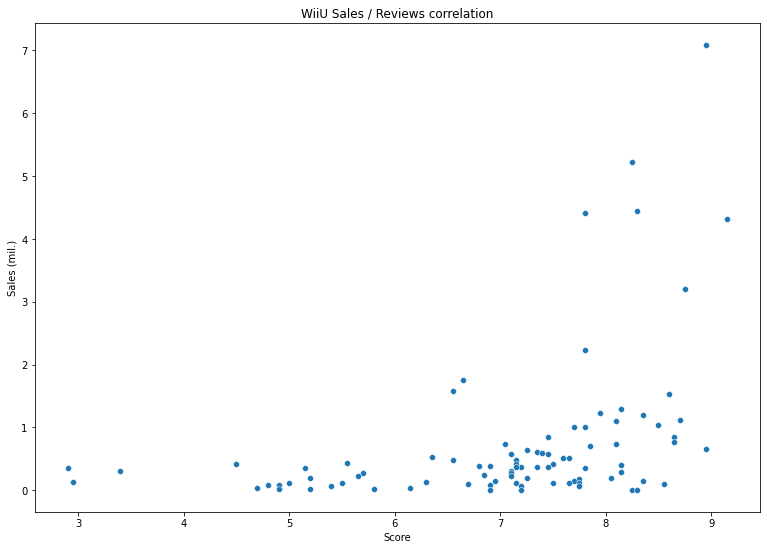

,total_sales,reviews_score
total_sales,1.000000,0.178567
reviews_score,0.178567,1.000000


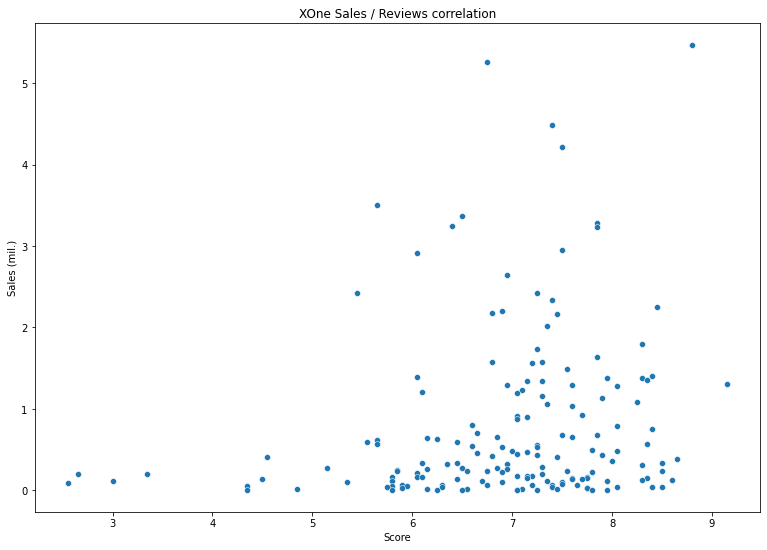

In [81]:
potential_platforms_ids = [id for id in potential_popular_platforms_ids if id != (platform_ref == 'PS4').idxmax()]
# print(potential_platforms_ids)

for platform_id in potential_platforms_ids:
    display(potential_popular_platforms_slice
            .query(f'platform_id == @platform_id')[['total_sales', 'reviews_score']]
            .corr())
    plot_platform_review_sales_scatter(platform_id)

WiiU's scores appear to have a weak positive correlation to sales,  
while Xbox One has a very weak positive correlation.

<a class="anchor" id="3-analysis_genres"></a>
### Comparison of genres
[up](#3-analysis)

In [82]:
genre_ref

0           Action
1        Adventure
2         Fighting
3             Misc
4         Platform
5           Puzzle
6           Racing
7     Role-Playing
8          Shooter
9       Simulation
10          Sports
11        Strategy
Name: genre, dtype: object

In [83]:
popular_genres_slice = potential_popular_platforms_slice.join(genre_ref, on='genre_id')

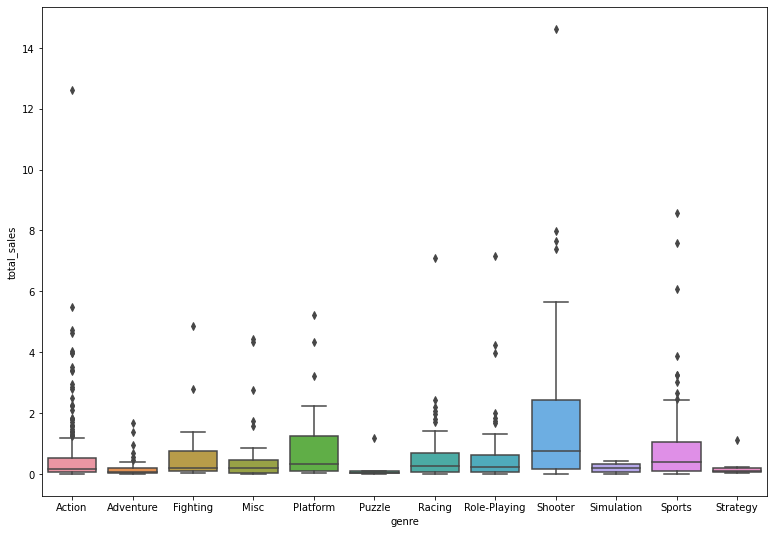

In [84]:
# plt.ylim((0,4))
sns.boxplot(data=popular_genres_slice.sort_values('genre'), x='genre', y='total_sales');

In [85]:
popular_genres_slice.groupby('genre')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,293.0,0.520410,1.096619,0.01,0.0500,0.150,0.5100,12.62
Adventure,45.0,0.204222,0.348819,0.01,0.0200,0.070,0.1800,1.66
Fighting,30.0,0.579000,1.003863,0.02,0.0825,0.185,0.7650,4.87
Misc,61.0,0.460328,0.862320,0.01,0.0300,0.190,0.4500,4.42
Platform,34.0,0.886765,1.251984,0.02,0.1000,0.340,1.2500,5.23
Puzzle,5.0,0.268000,0.516691,0.01,0.0200,0.020,0.1000,1.19
Racing,42.0,0.709524,1.224884,0.01,0.0625,0.245,0.6975,7.09
Role-Playing,72.0,0.589306,1.102054,0.01,0.0700,0.230,0.6225,7.17
Shooter,89.0,1.740449,2.336063,0.01,0.1500,0.760,2.4200,14.63


The most profitable genres (Shooter, Platform and Sports) have positively skewed distributions:
- lower median than mean
- higher upper extreme
- overall a larger range of values

There are outliers that pull the average up (best sellers).  
\* Action (and to a lesser extent - Sports) has many outliers which are high grossing games,  
&nbsp;&nbsp;but in general most of its other entries fail to reach those numbers.

#### Best sellers of profitable genres:

In [86]:
def best_sellers(genre, top=2):
    """Display the top N best sellers from each genre"""
    
    return (popular_genres_slice
            .query('genre == @genre')
            .sort_values('total_sales', ascending=False)
            .head(top)
            [['name', 'genre', 'year_of_release', 'total_sales']])

In [87]:
pd.concat([
    best_sellers('Shooter'),
    best_sellers('Platform'),
    best_sellers('Sports')
]).set_index('genre')

,name,year_of_release,total_sales
genre,,,
Shooter,Call of Duty: Black Ops 3,2015,14.63
Shooter,Star Wars Battlefront (2015),2015,7.98
Platform,New Super Mario Bros. U,2012,5.23
Platform,Super Mario 3D World,2013,4.32
Sports,FIFA 16,2015,8.58
Sports,FIFA 17,2016,7.60


#### Best sellers of unprotifable genres:

In [88]:
pd.concat([
    best_sellers('Adventure'),
    best_sellers('Strategy'),
    best_sellers('Puzzle')
]).set_index('genre')

,name,year_of_release,total_sales
genre,,,
Adventure,Until Dawn,2015,1.66
Adventure,Rise of the Tomb Raider,2015,1.38
Strategy,Pikmin 3,2013,1.12
Strategy,Angry Birds Star Wars,2013,0.22
Puzzle,Captain Toad: Treasure Tracker,2014,1.19
Puzzle,Scribblenauts Unmasked: A DC Comics Adventure,2013,0.10


If a genre has many best sellers, it will positively impact the mean and the distribution of the entire genre.

<a class="anchor" id="3-analysis_conclusions"></a>
### Conclusions
[up](#3-analysis)

* Home consoles started to appear and became common in the early 90’s.
* Highest total grossing platforms up until 2017 were:  
PS2, Xbox 360, PS3, Wii, DS and PS.
* Looking at those platforms, the distributions of sales appear similar,  
although they are spread across different ranges of years:
PS being the oldest, and PS3 the newest.  
It shows a trend of a new console rising in popularity within 5 years,  
then another console appears and starts to climb, while the first one's popularity is continuously dropping  
\- in effect moving opposite to one another.
* Taking into account this spotted trend, zoomed-in on the range of 2012-2016 (last 5 years),  
which had no titles prior to that (new consoles):  
Xbox One, PS4 and Wii U.  
The sales plot showed that Xbox One and PS4 had stable increases in sales over the years,  
Wii U had a small increase in the first year, and then plummeted over the following years  
\- making it a good candidate for targeted  advertising.
* Checked correlation of reviews scores with sales for these 3 platforms,  
and found out that while PS4 and Xbox One had very weak correlation,  
Wii had somewhat weak correlation  
\- that might imply relation between Wii U’s bad reviews and plummeting sales,  
&nbsp;&nbsp;but that can’t be concluded based on this alone, more statistical research should be conducted separately to answer this.
* Genres with highest total sales are Shooter (by far), Platform and Sports.  
Each of these genres has a mass of high grossing games, and some best sellers too.  
Also the Action and Sports genres have many “Best Sell”-ing outliers, while most of their entries are only mediocre.

<a class="anchor" id="4-region_profiles"></a>
## Regional user profiles
***
[back to Table of Contents](#0_toc)

Splitting last 5 years' data by region, in order to provide finer targeted conclusions,  
then exploring platforms, genres, ratings and its' correlation to sales.

1. [Top 5 platforms by region](#4-region_platforms)
2. [Top 5 genres by region](#4-region_genres)
3. [ESRB ratings](#4-region_esrb)
<br />[Conclusions](#4-region_conclusions)

In [89]:
relevant_years_df = df.query('year_of_release in @relevant_years')

In [90]:
regions = {
    'NA': 'North America',
    'EU': 'Europe',
    'JP': 'Japan'
}
region_columns = {region: f'{region.lower()}_sales' for region in regions.keys()}

In [91]:
def iterate_regions(df, func):
    return [func(df, region) for region in region_columns.keys()]
        
# iterate_regions(df, lambda df, col, region:print(f'{region}: {col}'))

In [92]:
def plot_by_region(df, region, compare, top=5, xticks_rotation=45):
    column = region_columns[region]
    region_name = regions[region]
    sorted_df = df[[compare, column]].groupby(compare).mean().sort_values(column, ascending=False)
    
    ax = sns.barplot(data=df, x=compare, y=column,
                     order=sorted_df.index, ci=False)
    plt.title(f'{region_name} top {top} {compare}s')
    plt.ylabel('Sales (mil.)')
    plt.xlabel(compare.capitalize())
    plt.xticks(rotation=xticks_rotation, ha='right')
    plt.draw()
    
    # xticks = ax.get_xticklabels()
    # all_x_values = [label.get_text() for label in xticks]
    top_x_values = sorted_df[:top]
    
    # for bar, xtick, x_value in zip(ax.patches, xticks, all_x_values):
    #     if x_value in top_x_values.index:
    #         xtick.set_color(bar.get_facecolor())
    #         xtick.set_text(f'{xtick.get_text()} ({bar.get_height():.2f})')
    
    for i, bar in enumerate(ax.patches):
        if i < top:
            ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=14, xytext=(0, -14),
                   textcoords='offset points', color='white')

    # ax.set_xticklabels(label.get_text() for label in xticks)
    plt.show()
    
    return top_x_values
    
# plot_by_region(df.join(platform_ref, on='platform_id'), 'NA', compare='platform')
# plot_by_region(df.join(genre_ref, on='genre_id'), 'NA', compare='genre')

In [93]:
def one_hot_encoding(df):
    return (~pd.concat(df, axis=1).isna()).astype('int').T

In [94]:
def plot_venn(df, names):
    
    one_hot = one_hot_encoding(df)
    # display(one_hot)
    
    v = venn3(
            one_hot.values,
            names if names else one_hot.index.to_list(),
            subset_label_formatter=lambda x:None)
    
    _labels = { k: ''.join([str(i) for i in column.values]) 
               for k, column in one_hot.iteritems() }
    
    for k, label_id in _labels.items():
        _previous = v.get_label_by_id(label_id).get_text()
        label = v.get_label_by_id(label_id)
        label.set_text(_previous + '\n' + k if _previous else k)
        label.set_size(12)
        
# plot_venn(top_platforms_by_region, regions.values())

<a class="anchor" id="4-region_platforms"></a>
### Top 5 platforms by region
[up](#4-region_profiles)

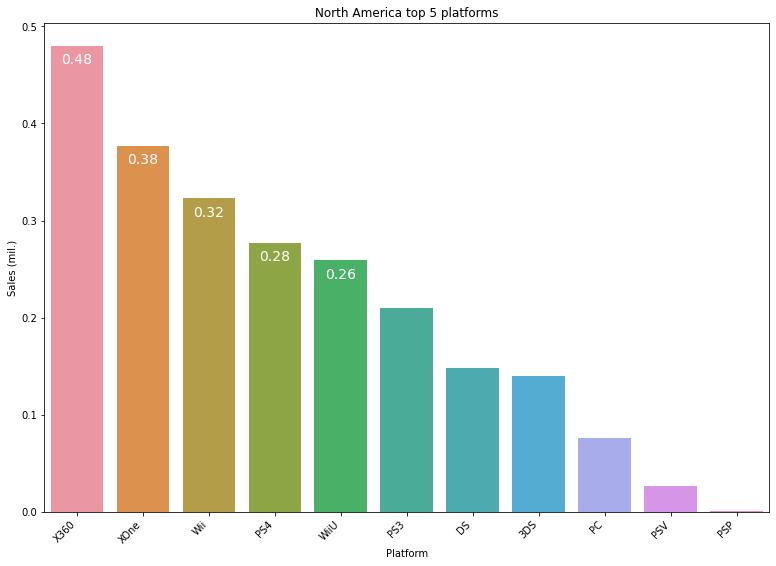

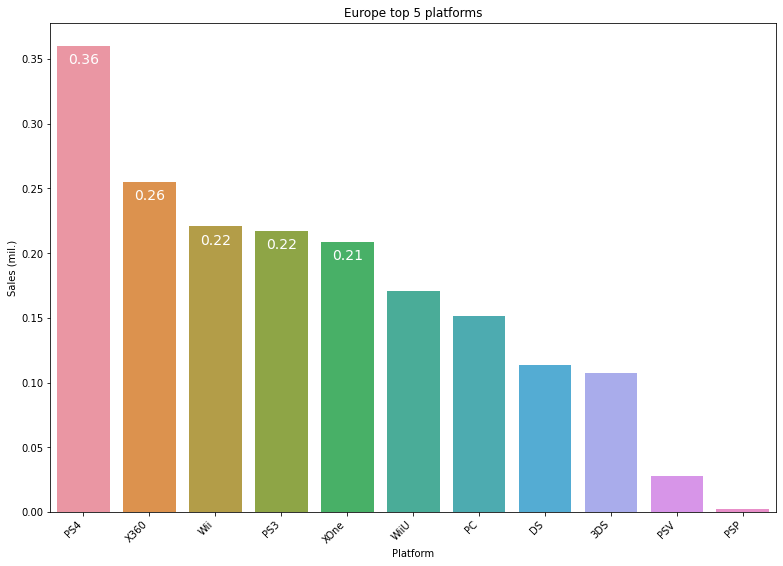

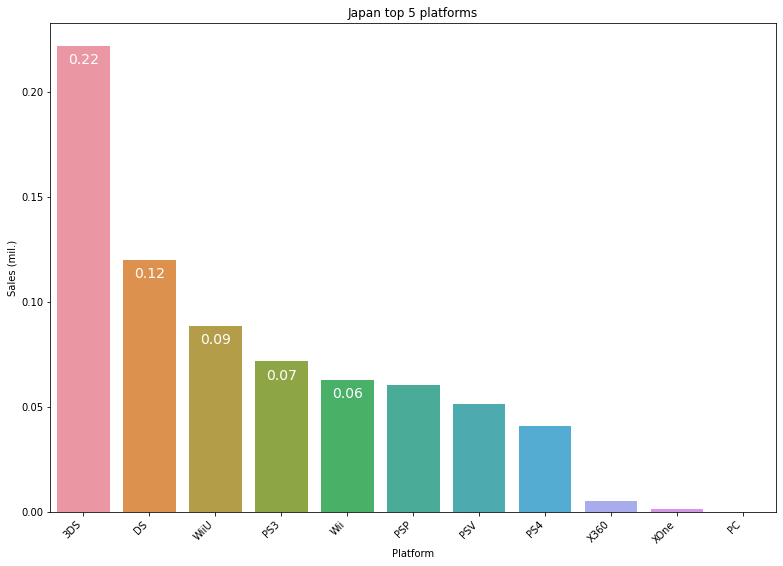

In [95]:
top_platforms_by_region = iterate_regions(
    relevant_years_df.join(platform_ref, on='platform_id'),
    lambda df, region: plot_by_region(df, region, compare='platform'))

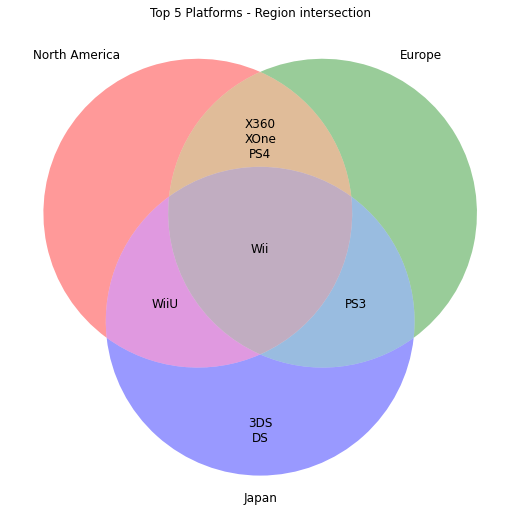

In [96]:
plot_venn(top_platforms_by_region, regions.values())
plt.title('Top 5 Platforms - Region intersection');

In [97]:
relevant_years_df[[*region_columns.values()]].sum().rename('total').to_frame().T.rename(
    columns=dict(zip(region_columns.values(), regions.values())))

,North America,Europe,Japan
total,590.97,506.81,192.58


* North America and Europe are bigger markets than Japan by itself,  
hence higher total sales.
* Wii U is shared between North America and Japan,  
PS3 is shared between Europe and Japan,  
and North America and Europe share Xbox 360, Xbox One and PS4.
* Wii is shared among all regions.


* For North America, Xbox 360 and Xbox One take the lead (created by American Microsoft).
* For Europe, PS4 (Japanese) and Xbox 360 (American) take the lead.
* For Japan, 3DS and DS take the lead (created by Japanese Nintendo).

<a class="anchor" id="4-region_genres"></a>
### Top 5 genres by region
[up](#4-region_profiles)

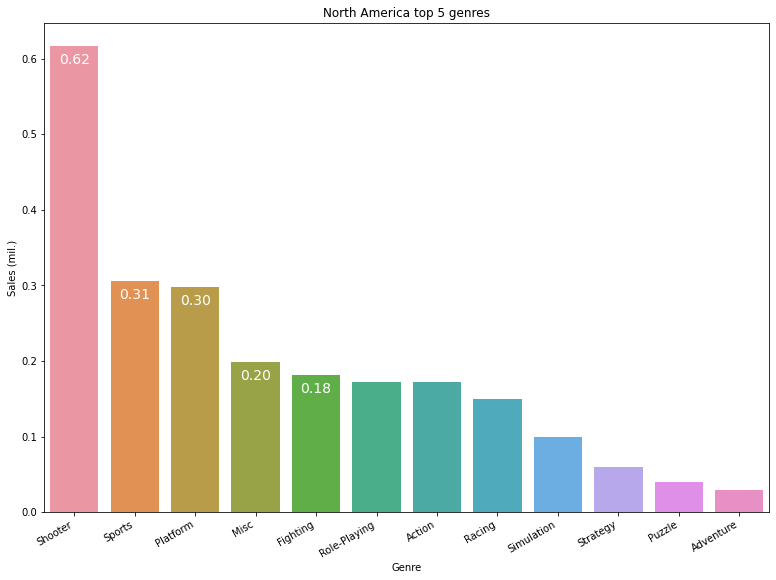

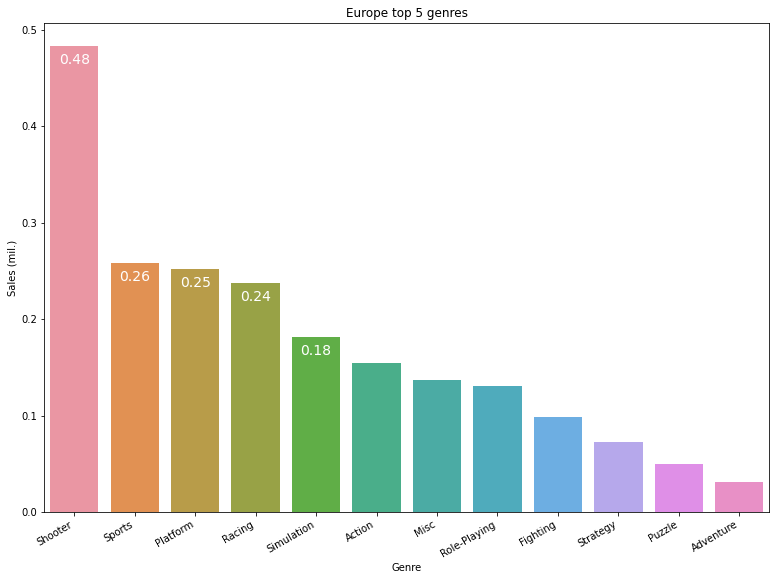

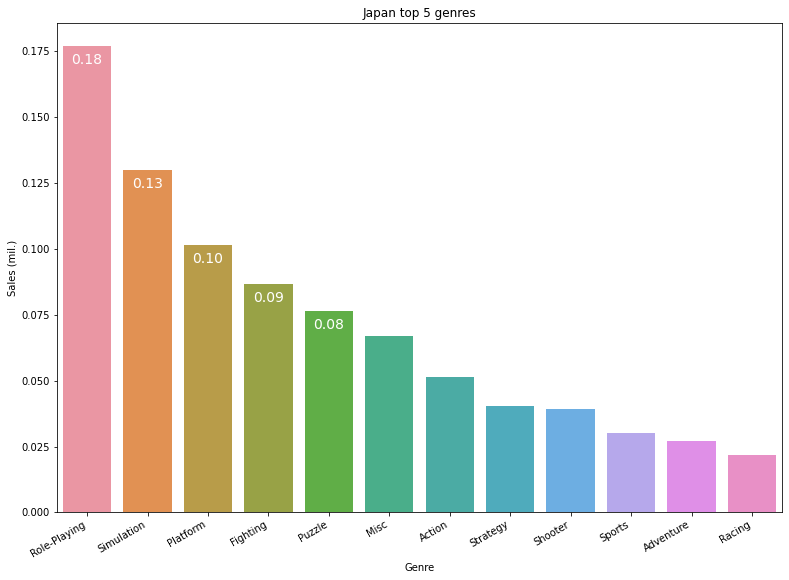

In [98]:
top_genres_by_platform = iterate_regions(
    relevant_years_df.join(genre_ref, on='genre_id'),
    lambda df, region: plot_by_region(df, region, compare='genre', xticks_rotation=30))

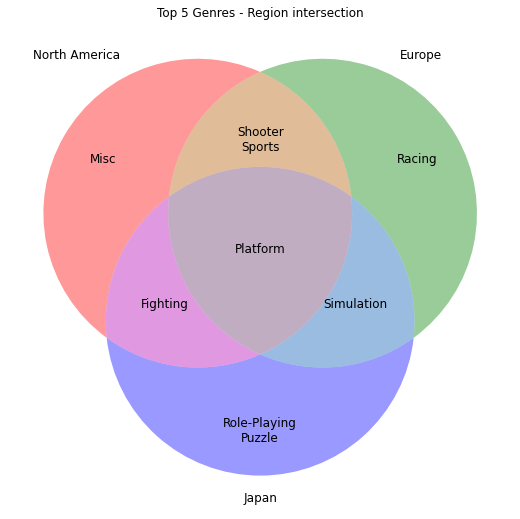

In [99]:
plot_venn(top_genres_by_platform, regions.values())
plt.title('Top 5 Genres - Region intersection');

* Platform is shared between all regions
* Shooter and Sports are shared between North America and Europe
* Fighting is shared between North America and Japan
* Simulation is shared between Europe and Japan


* For North America, Shooter (0.62) is the clear winner with almost twice as much revenue as the next genre - Sports (0.30).
* For Europe, it's almost the same as North America, Shooter with 0.48 and Sports with 0.26.
* Japan is completely different, Role-Playing being first with 0.18 and runner-up Simulation having 0.13.

<a class="anchor" id="4-region_esrb"></a>
### ESRB ratings
[up](#4-region_profiles)

In [100]:
def plot_correlation_by_region(df, region, compare):
    column = region_columns[region]
    region_name = regions[region]
    
    ax = sns.scatterplot(data=df, x=compare, y=column)
    plt.title(f'{region_name} sales by {compare}')
    plt.ylabel('Sales (mil.)')
    plt.xlabel(compare.capitalize())
    plt.show()
    
# plot_correlation_by_region(df.join(rating_ref, on='rating_id'), 'NA', compare='rating')

Removing 'Unknown' genre values.

In [101]:
ratings_df = relevant_years_df.join(rating_ref, on='rating_id')
ratings_df = ratings_df.where(ratings_df['rating'] != 'Unknown', np.NaN).dropna()

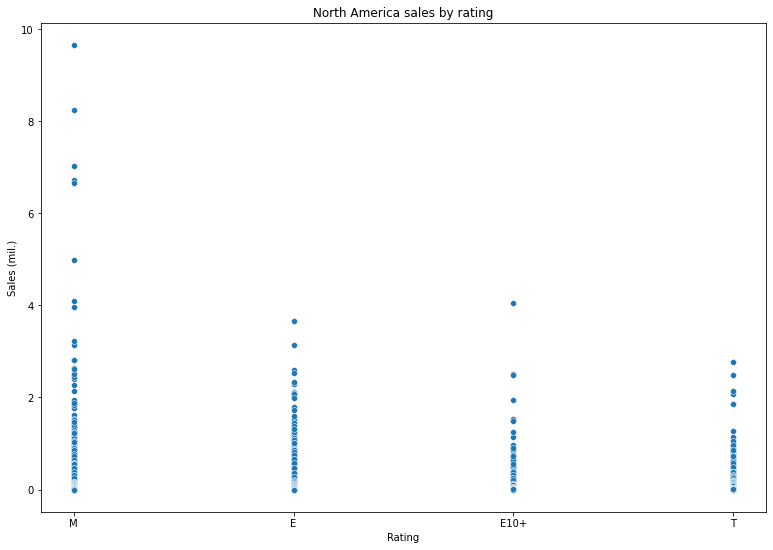

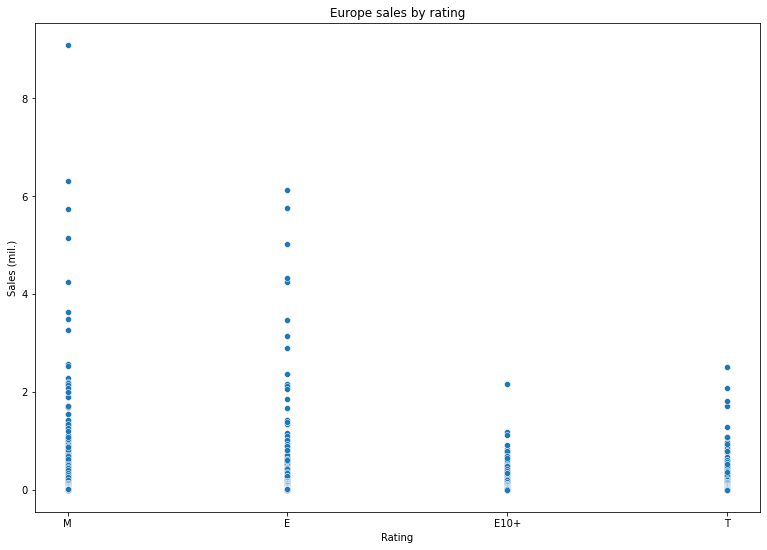

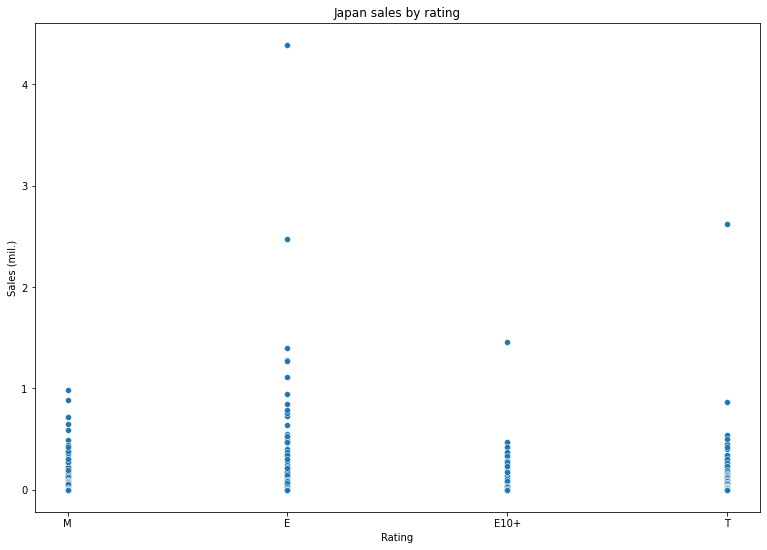

In [102]:
iterate_regions(
    ratings_df,
    lambda df, region: plot_correlation_by_region(df, region, compare='rating'));

It seems there are less total sales in Japan for 'M' rated games, in relation to the other ratings,  
compared to North America and Europe.  
Checking correlation matrix:

In [103]:
display(
    md('ESRB Ratings to Region sales correlation:'),
    (pd.concat([
        ratings_df[['na_sales', 'eu_sales', 'jp_sales']],
        pd.get_dummies(ratings_df['rating']),
    ], axis=1)
     .corr()
     .loc[[*ratings_df['rating'].unique()]][[*region_columns.values()]]))

ESRB Ratings to Region sales correlation:

,na_sales,eu_sales,jp_sales
M,0.145718,0.129990,-0.057413
E,0.018979,0.055543,0.098676
E10+,-0.042125,-0.066310,-0.048630
T,-0.139752,-0.136141,0.011952


There is no correlation between ESRB ratings and sales.

<a class="anchor" id="4-region_conclusions"></a>
### Conclusions

* Most popular platforms over the past 5 years are:  
Wii, Wii U, PS3, Xbox360, Xbox One, PS 4, 3DS and DS.  
* There is some variation between the markets, and it is based on the titles being released and heavily promoted in different regions.  
* Also, North America and Europe being continents - have higher total sales than Japan.  
* Japanese gamers tend to like different genres than North Americans and Europeans, which have similar taste in games.  
It may relate to the different culture of the gamers,  
and also to the consoles and titles being available.
* ESRB ratings have not been found to have a correlation to sales, in any region.

<a class="anchor" id="5-hypotheses"></a>
## Hypotheses
***
[back to Table of Contents](#0_toc)

There are 2 hypotheses to be tested:
1. [User ratings of Xbox One and PC platforms](#5-platforms_user_ratings)
2. [User ratings of Action and Sports genres](#5-genres_user_ratings)
<br />[Conclusions](#5-hypotheses_conclusions)

a significance level of .05 signifies a 5% risk of deciding that an effect exists when it does not exist.  
\- https://statisticsbyjim.com/hypothesis-testing/hypothesis-tests-significance-levels-alpha-p-values/

In [104]:
def test_levene(df, center, alpha=.05, **kwargs):
    """Perform Levene test for equal variances."""
    
    groups = [v for k,v in list(df)]
    
    results = st.levene(groups[0], groups[1], center=center, **kwargs)
    print(f'p-value: {results.pvalue}\nis p-value < alpha ?\n\t{results.pvalue < alpha}')

    if results.pvalue < alpha:
        print("We reject the null hypothesis")
    else:
        print("We can't reject the null hypothesis")

In [105]:
def test_mannwhitneyu(df, alpha=.05, **kwargs):
    """Perform the Mann-Whitney U rank test on two independent samples."""
    
    groups = [v for k,v in list(df)]
    
    results = st.mannwhitneyu(groups[0], groups[1], **kwargs)
    print(f'p-value: {results.pvalue}\nis p-value < alpha ?\n\t{results.pvalue < alpha}')

    if results.pvalue < alpha:
        print("We reject the null hypothesis")
    else:
        print("We can't reject the null hypothesis")

<a class="anchor" id="5-platforms_user_ratings"></a>
### Xbox One and PC - avg. user ratings hypothesis
[up](#5-hypotheses)

<!-- null hypothesis: The average user ratings of the Xbox One and PC platforms are the same.  
alternative hypothesis: The average user ratings of the Xbox One and PC platforms differ. -->

Testing whether Xbox One user ratings and PC user ratings belong to the same population.

$$H_0: F_{X_{Xbox One}}(x) = F_{X_{PC}}(x)$$
$$H_A: F_{X_{Xbox One}}(x) \neq F_{X_{PC}}(x)$$
$$\text{Significance level } \alpha = 0.05$$

In [106]:
test_platforms = ['XOne', 'PC']

In [107]:
ratings_platforms_df = (ratings_df
                        .join(platform_ref, on='platform_id')
                        .dropna()
                        [['platform', 'user_score']]
                        .query('platform in @test_platforms')
                        .groupby('platform'))

Checking variance of platforms:

In [108]:
ratings_platforms_df.apply(lambda x:np.var(x))['user_score']

platform
PC      2.820941
XOne    1.780141
Name: user_score, dtype: float64

Checking whether the difference of variance is statistically significant:

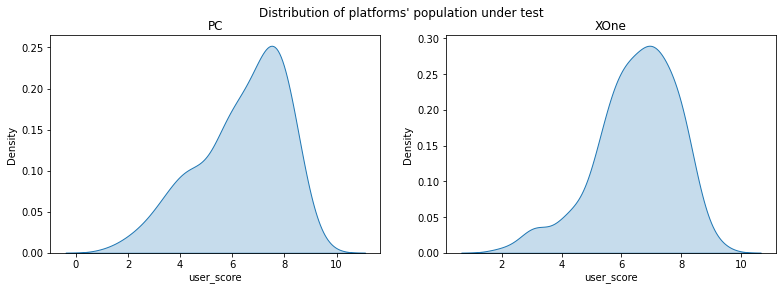

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
for i, (name, group) in enumerate(ratings_platforms_df):
    ax = axes[i]
    ax.set_title(name)
    sns.kdeplot(data=group, x='user_score', ax=ax, fill=True)
plt.suptitle('Distribution of platforms\' population under test')
plt.show();

The distributions are similarly left-skewed.  
Performing Levene test for variance equality, using center='median' as per documentation:  
"‘median’ : Recommended for skewed (non-normal) distributions"

In [110]:
test_levene(ratings_platforms_df['user_score'], center='median')

p-value: 0.0038494473989192884
is p-value < alpha ?
	True
We reject the null hypothesis


The small p-value suggests that the populations do not have equal variances.

In [111]:
test_mannwhitneyu(ratings_platforms_df['user_score'])

p-value: 0.9845387296938597
is p-value < alpha ?
	False
We can't reject the null hypothesis


In conclusion: Samples are statistically likely to be from the same population.

<a class="anchor" id="5-genres_user_ratings"></a>
### Action and Sports - avg. user ratings hypothesis
[up](#5-hypotheses)

<!-- null hypothesis: The average user ratings of Action and Sports genres are the same.  
alternative hypothesis: The average user ratings of Action and Sports genres differ. -->

Testing whether user ratings for the Action genre and user ratings for the Sports genre belong to the same population.

$$H_0: F_{X_{Action}}(x) = F_{X_{Sports}}(x)$$
$$H_A: F_{X_{Action}}(x) \neq F_{X_{Sports}}(x)$$
$$\text{Significance level } \alpha = 0.05$$

In [112]:
test_genres = ['Action', 'Sports']

In [113]:
ratings_genres_df = (ratings_df
                        .join(genre_ref, on='genre_id')
                        .dropna()
                        [['genre', 'user_score']]
                        .query('genre in @test_genres')
                        .groupby('genre'))

In [114]:
ratings_genres_df.apply(lambda x:np.var(x))['user_score']

genre
Action    1.754061
Sports    2.003287
Name: user_score, dtype: float64

Checking whether the difference of variance is statistically significant:

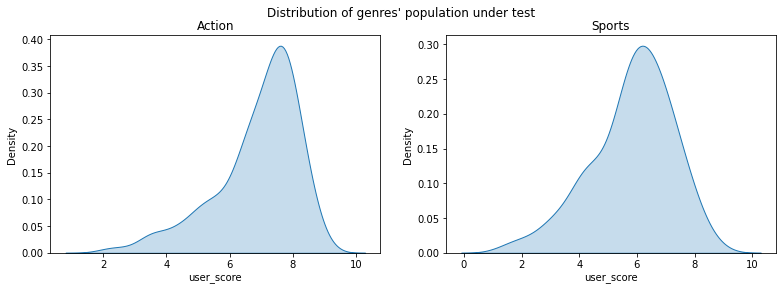

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
for i, (name, group) in enumerate(ratings_genres_df):
    ax = axes[i]
    ax.set_title(name)
    sns.kdeplot(data=group, x='user_score', ax=ax, fill=True)
plt.suptitle('Distribution of genres\' population under test')
plt.show();

The distributions are similarly left-skewed.  
Performing Levene test for variance equality, using center='median' as per documentation:  
"‘median’ : Recommended for skewed (non-normal) distributions"

In [116]:
test_levene(ratings_platforms_df['user_score'], center='median')

p-value: 0.0038494473989192884
is p-value < alpha ?
	True
We reject the null hypothesis


The small p-value suggests that the populations do not have equal variances.

In [117]:
test_mannwhitneyu(ratings_genres_df['user_score'])

p-value: 9.254864495327981e-16
is p-value < alpha ?
	True
We reject the null hypothesis


In conclusion: Samples are statistically unlikely to be from the same population.

<a class="anchor" id="5-hypotheses_conclusions"></a>
### Conclusions
[up](#5-hypotheses)

Xbox One and PC samples are statistically likely to be from the same population.  
Action and Sports samples, on the other hand, are statistically unlikely to be from the same population.

<a class="anchor" id="6-conclusions"></a>
## Overall Conclusions
***
[back to Table of Contents](#0_toc)

Highlighting the findings of the conducted analysis:
* In general, most profitable consoles for the next year are presumed to be:  
Xbox One, PS4 and Wii U  
(based on research data up until 2016, prediction made for 2017).
* More detailed review:
    * North America:  
    Xbox One, PS4 and Wii U (newer consoles)  
    Xbox 360 and Wii (older consoles)
    * Europe:  
    PS4 and Xbox One (newer consoles)  
    Xbox 360, PS3 and Wii (older consoles)
    * Japan:  
    3DS, Wii U (newer consoles)  
    DS, PS3, Wii (older consoles)
* Most consoles start to shine after 2-3 years,  
peaking at 5 years when the technology behind them is well researched, ripe and used proficiently.  
  After that, they slowly wither away and lose popularity in the span of another 5 years.
* Worthwhile genres for North America and Europe pretty much overlap: Shooter, Sports and Platform.  
North Americans also like Fighting games.  
Europeans also like Racing.  
Japan is a different market, favouring: Role Playing, Simulation, Platform and Fighting.  
* ESRB ratings, user reviews and critic reviews show little correlation to sales performance.  
  Behavioural research is needed in order to draw finer conclusions regarding reviews and potential buyers’ psychology.
  
The overall conclusion is to invest in advertisements targeting the popular genres per region, and the newer generation of consoles that have sells rising.